# Plots/Tables
1. Expectation model
    - Table showing kickers with highest fgoe
3. Kicker Specific Model (for fourth down decision model)
    - probabily plots demonstrating difference in probability against distance
    - Table showing the teams that were most aggressive in going for low probability field goals
    - curve of drafted verse undrafted kickers

# Process:
1. Logistic regression trained for each kick, (or maybe bagged and trained on every 100 kicks) for temporal split
2. Calculate FGPOE at the time of each kick
3. Feed FGPOE, environmental factors, and situational factors into heirachical baysian logistic regression

In [4]:
import os

import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import nfl_data_py as nfl

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.options.mode.copy_on_write = True

In [5]:
years = range(2000, 2024)
# cols = nfl.see_pbp_cols()

In [7]:
df_pbp = nfl.import_pbp_data(years, cache=True, alt_path='../../.cache/pbp')
df_pbp[df_pbp['field_goal_attempt'] == True].shape

2000 done.
2001 done.
2002 done.
2003 done.
2004 done.
2005 done.
2006 done.
2007 done.
2008 done.
2009 done.
2010 done.
2011 done.
2012 done.
2013 done.
2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
Downcasting floats.


(24471, 390)

In [8]:
variables = ['season','play_id','game_id','desc','kicker_player_name', 'kicker_player_id', 'field_goal_attempt', 
             'extra_point_attempt', 'fg_prob', 'field_goal_result', 'kick_distance']
df_fg = df_pbp[df_pbp['field_goal_attempt'] == True][variables].reset_index(drop=True)

df_fg['field_goal_made'] = df_fg['field_goal_result'].apply(lambda x: 1 if x == 'made' else 0)


df_schedules = nfl.import_schedules(years)

sched_cols = ['game_id','roof','surface','wind','temp','stadium_id','stadium']
df = df_fg.merge(df_schedules[sched_cols], on='game_id', how='left')

In [9]:
#count the number of field goals attempted and made by distance
df_binom = df.groupby('kick_distance').agg({'field_goal_attempt':'count','field_goal_made':'sum'}).reset_index()
df_binom = (df_binom.sort_values(by='kick_distance', ascending=True)
              .rename({'field_goal_attempt':'field_goal_attempts','field_goal_made':'field_goal_makes'}, axis=1))

df_binom['fg_pct'] = df_binom['field_goal_makes'] / df_binom['field_goal_attempts']
df_binom.head()

,kick_distance,field_goal_attempts,field_goal_makes,fg_pct
0,18.0,34,34,1.000000
1,19.0,239,237,0.991632
2,20.0,495,490,0.989899
3,21.0,524,516,0.984733
4,22.0,629,617,0.980922


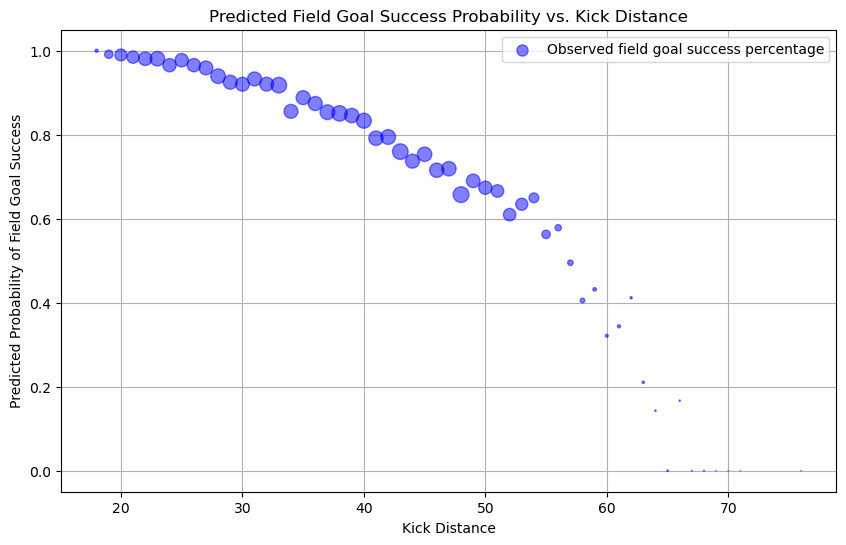

In [10]:
import matplotlib.pyplot as plt

# Extract the kick distances (as integers) and corresponding success percentages
x = df_binom['kick_distance'].values
y = df_binom['fg_pct'].values
marker_sizes = df_binom['field_goal_attempts'].values * 0.15

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the scatter plot
ax.scatter(x, y, color='blue', s=marker_sizes, label='Observed field goal success percentage', alpha=0.5)

# Set labels, title, and legend
ax.set_xlabel('Kick Distance')
ax.set_ylabel('Predicted Probability of Field Goal Success')
ax.set_title('Predicted Field Goal Success Probability vs. Kick Distance')
ax.legend()

# Send gridlines to the back
ax.set_axisbelow(True)

# Add gridlines
ax.grid()

# Show the plot
plt.show()


In [11]:
import pandas as pd
import numpy as np

# Maximum number of attempts in any bin
max_attempts = df_binom['field_goal_attempts'].max()

oversampled_rows = []

# Adding additional records to precisely match max_attempts
for _, row in df_binom.iterrows():
    additional_rows_needed = max_attempts - (row['field_goal_attempts'])
    field_goal_makes = int((row['field_goal_makes'] / row['field_goal_attempts']) * max_attempts)
    oversampled_rows.extend([np.array([row.iloc[0], max_attempts, field_goal_makes])])
    
df_oversampled = pd.DataFrame(oversampled_rows, columns=df_binom.columns[:-1])

In [12]:
# create a new dataframe with the data as individual attempts intead of binomial
df_attempts = pd.DataFrame(columns=['kick_distance','field_goal_made'])

unraveled_rows = None

for row in df_oversampled.itertuples(index=False):
    makes = np.tile((row.kick_distance, 1), (int(row.field_goal_makes),1))
    misses = np.tile((row.kick_distance, 0), (int(row.field_goal_attempts - row.field_goal_makes),1))
    if unraveled_rows is None:
        unraveled_rows = np.vstack((makes,misses))
    else:
        unraveled_rows = np.vstack((unraveled_rows, makes,misses))


df_fg_oversampled = pd.DataFrame(unraveled_rows, columns=['kick_distance','field_goal_made'])

In [13]:
df_fg.head()

,season,play_id,game_id,desc,kicker_player_name,kicker_player_id,field_goal_attempt,extra_point_attempt,fg_prob,field_goal_result,kick_distance,field_goal_made
0,2000,2771.0,2000_01_ARI_NYG,"(:05) C.Blanchard 32 yard field goal is GOOD, ...",C.Blanchard,00-0001343,1.0,0.0,0.883224,made,32.0,1
1,2000,467.0,2000_01_BAL_PIT,"(8:21) M.Stover 23 yard field goal is GOOD, Ce...",M.Stover,00-0015784,1.0,0.0,0.956671,made,23.0,1
2,2000,1810.0,2000_01_BAL_PIT,"(:11) M.Stover 26 yard field goal is GOOD, Cen...",M.Stover,00-0015784,1.0,0.0,0.920074,made,26.0,1
3,2000,2027.0,2000_01_BAL_PIT,"(15:00) M.Stover 33 yard field goal is GOOD, C...",M.Stover,00-0015784,1.0,0.0,0.859976,made,33.0,1
4,2000,2250.0,2000_01_BAL_PIT,"(11:31) K.Brown 45 yard field goal is No Good,...",K.Brown,00-0001980,1.0,0.0,0.686317,missed,45.0,0


In [14]:
df_binom

,kick_distance,field_goal_attempts,field_goal_makes,fg_pct
0,18.0,34,34,1.000000
1,19.0,239,237,0.991632
2,20.0,495,490,0.989899
3,21.0,524,516,0.984733
4,22.0,629,617,0.980922
5,23.0,734,720,0.980926
6,24.0,609,588,0.965517
7,25.0,620,606,0.977419
8,26.0,612,591,0.965686
9,27.0,660,633,0.959091


In [15]:
def probabalistic_oversampling(df_fg, year: int) -> pd.DataFrame:
    """ Oversample field goal attempts to create a binomial distribution
    
    Parameters
        df_fg: pbp dataframe with only field goal attempts
            cols: 'season', 'kick_distance', 'field_goal_made' 
        year: disclusive upper bound on the seasons to include
        
    Returns
        df_fg_oversampled: pbp dataframe with individual field goal attempts
            cols: 'kick_distance', 'field_goal_made'
    """

    #count the number of field goals attempted and made by distance
    df_binom = df_fg.groupby('kick_distance').agg({'field_goal_attempt':'count','field_goal_made':'sum'}).reset_index()
    df_binom = (df_binom.sort_values(by='kick_distance', ascending=True)
                  .rename({'field_goal_attempt':'field_goal_attempts','field_goal_made':'field_goal_makes'}, axis=1))

    # Maximum number of attempts in any bin
    max_attempts = df_binom['field_goal_attempts'].max()

    oversampled_rows = []

    # Adding additional records to precisely match max_attempts
    for _, row in df_binom.iterrows():
        additional_rows_needed = max_attempts - (row['field_goal_attempts'])
        field_goal_makes = int((row['field_goal_makes'] / row['field_goal_attempts']) * max_attempts)
        oversampled_rows.extend([np.array([row.iloc[0], max_attempts, field_goal_makes])])

    df_oversampled = pd.DataFrame(oversampled_rows, columns=df_binom.columns[:-1])

    # create a new dataframe with the data as individual attempts intead of binomial
    df_attempts = pd.DataFrame(columns=['kick_distance','field_goal_made'])

    unraveled_rows = None

    for row in df_oversampled.itertuples(index=False):
        makes = np.tile((row.kick_distance, 1), (int(row.field_goal_makes),1))
        misses = np.tile((row.kick_distance, 0), (int(row.field_goal_attempts - row.field_goal_makes),1))
        if unraveled_rows is None:
            unraveled_rows = np.vstack((makes,misses))
        else:
            unraveled_rows = np.vstack((unraveled_rows, makes,misses))


    df_fg_oversampled = pd.DataFrame(unraveled_rows, columns=['kick_distance','field_goal_made'])

    return df_fg_oversampled

In [16]:
df_fg.head()

,season,play_id,game_id,desc,kicker_player_name,kicker_player_id,field_goal_attempt,extra_point_attempt,fg_prob,field_goal_result,kick_distance,field_goal_made
0,2000,2771.0,2000_01_ARI_NYG,"(:05) C.Blanchard 32 yard field goal is GOOD, ...",C.Blanchard,00-0001343,1.0,0.0,0.883224,made,32.0,1
1,2000,467.0,2000_01_BAL_PIT,"(8:21) M.Stover 23 yard field goal is GOOD, Ce...",M.Stover,00-0015784,1.0,0.0,0.956671,made,23.0,1
2,2000,1810.0,2000_01_BAL_PIT,"(:11) M.Stover 26 yard field goal is GOOD, Cen...",M.Stover,00-0015784,1.0,0.0,0.920074,made,26.0,1
3,2000,2027.0,2000_01_BAL_PIT,"(15:00) M.Stover 33 yard field goal is GOOD, C...",M.Stover,00-0015784,1.0,0.0,0.859976,made,33.0,1
4,2000,2250.0,2000_01_BAL_PIT,"(11:31) K.Brown 45 yard field goal is No Good,...",K.Brown,00-0001980,1.0,0.0,0.686317,missed,45.0,0


In [63]:
def probabalistic_oversampling(df_fg, year: int) -> pd.DataFrame:
    """ Oversample field goal attempts to create a binomial distribution
    
    Parameters
        df_fg: pbp dataframe with only field goal attempts
            cols: 'season', 'kick_distance', 'field_goal_made' 
        year: inclusive upper bound on the seasons to include
        
    Returns
        df_fg_oversampled: pbp dataframe with individual field goal attempts
            cols: 'kick_distance', 'field_goal_made'
    """

    df_fg = df_fg[df_fg['season'] <= year]

    df_fg['field_goal_attempt'] = 1

    df_binom = df_fg.groupby('kick_distance').agg({'field_goal_attempt':'count',
                                                   'field_goal_made':'sum'}).reset_index()
    df_binom = (df_binom.sort_values(by='kick_distance', ascending=True)
                        .rename({'field_goal_attempt':'n_attempts',
                                 'field_goal_made':'n_makes'}, axis=1))
    
    df_binom['p'] = df_binom['n_makes'] / df_binom['n_attempts']

    max_attempts = df_binom['n_attempts'].max()

    # Unravel the binomial distribution
    unraveled_rows = None
    for row in df_binom.itertuples(index=False):
        makes = np.tile((row.kick_distance, 1), (int(row.n_makes),1))
        misses = np.tile((row.kick_distance, 0), (int(row.n_attempts - row.n_makes),1))
        if unraveled_rows is None:
            unraveled_rows = np.vstack((makes,misses))
        else:
            unraveled_rows = np.vstack((unraveled_rows, makes,misses))

    df_fg_oversampled = pd.DataFrame(unraveled_rows, columns=['kick_distance','field_goal_made'])

    kick_distances = df_binom['kick_distance'].values


    rows = None
    for dist in range(18,77): # shortest fg is 18 yards, longest is 76
        if dist in kick_distances:
            n_attempts = (df_binom.loc[df_binom['kick_distance'] == dist, 'n_attempts']
                                .reset_index(drop=True).values[0])
        else:
            n_attempts = 0
        n_samples_to_add = max_attempts - n_attempts

        for i in range(n_samples_to_add):
            added_dist = False
            while(not added_dist): #TODO: at something to make sure you dont get stuck here
                dist_to_add = int(np.random.normal(0, 5))
                new_dist = dist + dist_to_add
                if new_dist in kick_distances:
                    added_dist = True
                    df_binom_new_dist = (df_binom.loc[df_binom['kick_distance'] == new_dist]
                                                .reset_index(drop=True))
                    n_attempts = df_binom_new_dist.n_attempts.values[0]
                    p = df_binom_new_dist.p.values[0]
                    field_goal_made = np.random.binomial(1, p)
                    if rows is None:
                        rows = np.array([dist, field_goal_made])
                    else:
                        rows = np.vstack((rows, [dist, field_goal_made]))
        
    df_fg_oversampled = pd.concat([df_fg_oversampled, 
                                   pd.DataFrame(rows, columns=['kick_distance','field_goal_made'])])
    breakpoint()

    df_b = df_fg_oversampled.groupby('kick_distance').agg({'kick_distance':'count','field_goal_made':'sum'}).rename({'kick_distance':'n_attempts'},axis=1).reset_index()

    df_b['p'] = df_b['field_goal_made'] / df_b['n_attempts']
    return df_fg_oversampled

def load_field_goal_pbp_data(years, include_enviorment: bool = False) -> pd.DataFrame:
    """ Load field goal data from the nfl_data_py package
    
    Parameters
        years: list of years to load data for
        include_enviorment: boolean to include enviorment data ('roof','surface','temp','wind',
            'stadium')
        
    Returns
        df_fg: pbp dataframe with only field goal attempts
            cols: 'season', 'kick_distance', 'field_goal_made' 
    """

    for year in years:
        if not os.path.exists(f'../.cache/pbp/season={year}'):
            nfl.cache_pbp(years=[year], alt_path='../.cache/pbp', downcast=True)

    df_fg = nfl.import_pbp_data(years=years, cache=True, alt_path='../.cache/pbp', downcast=False)
    df_fg = df_fg[df_fg['field_goal_attempt'] == True]

    df_fg['field_goal_made'] = df_fg['field_goal_result'].apply(lambda x: 1 if x == 'made' else 0)

    cols = ['season','game_id','kicker_player_name','kicker_player_id','kick_distance','field_goal_made']
    df_fg = df_fg[cols]

    if include_enviorment:
        df_schedules = nfl.import_schedules(years=years)
        sched_cols = ['game_id','roof','surface','wind','temp','stadium_id','stadium']
        df_fg = df_fg.merge(df_schedules[sched_cols], on='game_id', how='left')
    
    return df_fg


years = range(2000, 2024)

df_fg = load_field_goal_pbp_data(years)

df_proba_oversamp = probabalistic_oversampling(df_fg, 2024)

2000 done.
2001 done.
2002 done.
2003 done.
2004 done.
2005 done.
2006 done.
2007 done.
2008 done.
2009 done.
2010 done.
2011 done.
2012 done.
2013 done.
2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.


/Users/lukeneuendorf/miniforge3/envs/4th-down/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/lukeneuendorf/miniforge3/envs/4th-down/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/lukeneuendorf/miniforge3/envs/4th-down/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/Users/lukeneuendorf/miniforge3/envs/4th-down/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/Users/lukeneuendorf/miniforge3/envs/4th-down/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid featu

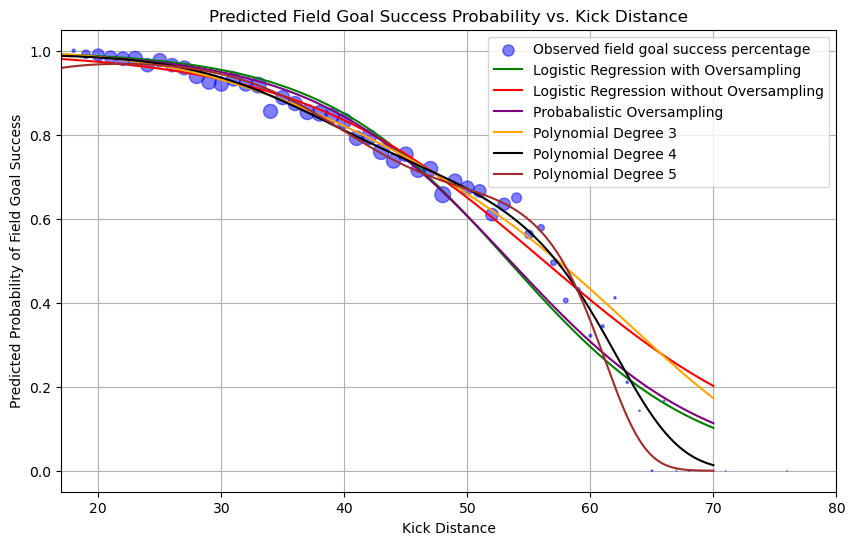

In [64]:
# fit a logistic regression model to the data df_fg_oversampled
X = df_fg_oversampled[['kick_distance']]
y = df_fg_oversampled['field_goal_made']

model_oversampled = LogisticRegression()
model_oversampled.fit(X, y)

# fit probabalistic oversampling to the data df_fg data
x = df_proba_oversamp['kick_distance'].values
y = df_proba_oversamp['field_goal_made'].values

model_proba_oversamp = LogisticRegression()
model_proba_oversamp.fit(x.reshape(-1,1), y)

# fit another logistic regression model to the data df_fg data
X = df_fg[['kick_distance']]
y = df_fg['field_goal_made']

model = LogisticRegression()
model.fit(X, y)

# fit a spline to the data df_fg data using sklearn
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

degree = 3
model_poly_3 = make_pipeline(PolynomialFeatures(degree), LogisticRegression())
model_poly_3.fit(X, y)

degree = 4
model_poly_4 = make_pipeline(PolynomialFeatures(degree), LogisticRegression())
model_poly_4.fit(X, y)

degree = 5
model_poly_5 = make_pipeline(PolynomialFeatures(degree), LogisticRegression())
model_poly_5.fit(X, y)

# plot the curve
x_values = np.linspace(0, 70, 1000)
y_values = model_oversampled.predict_proba(x_values.reshape(-1,1))[:,1]

# Extract the kick distances (as integers) and corresponding success percentages
x = df_binom['kick_distance'].values
y = df_binom['fg_pct'].values
marker_sizes = df_binom['field_goal_attempts'].values * 0.15

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the scatter plot
ax.scatter(x, y, color='blue', s=marker_sizes, label='Observed field goal success percentage', alpha=0.5)
ax.plot(x_values, y_values, color='green', label='Logistic Regression with Oversampling')

y_values = model.predict_proba(x_values.reshape(-1,1))[:,1]
ax.plot(x_values, y_values, color='red', label='Logistic Regression without Oversampling')

y_values = model_proba_oversamp.predict_proba(x_values.reshape(-1,1))[:,1]
ax.plot(x_values, y_values, color='purple', label='Probabalistic Oversampling')

y_values = model_poly_3.predict_proba(x_values.reshape(-1,1))[:,1]
ax.plot(x_values, y_values, color='orange', label='Polynomial Degree 3')

y_values = model_poly_4.predict_proba(x_values.reshape(-1,1))[:,1]
ax.plot(x_values, y_values, color='black', label='Polynomial Degree 4')

y_values = model_poly_5.predict_proba(x_values.reshape(-1,1))[:,1]
ax.plot(x_values, y_values, color='brown', label='Polynomial Degree 5')

# Set labels, title, and legend
ax.set_xlabel('Kick Distance')
ax.set_ylabel('Predicted Probability of Field Goal Success')
ax.set_title('Predicted Field Goal Success Probability vs. Kick Distance')
ax.legend()

# Send gridlines to the back
ax.set_axisbelow(True)

# limit x axis to 17 to 80
ax.set_xlim([17, 80])

# Add gridlines
ax.grid()

# Show the plot
plt.show()


In [60]:
dist = 70

print(model_poly_4.predict_proba(np.array([dist]).reshape(-1,1))[:,1])
print(model_proba_oversamp.predict_proba(np.array([dist]).reshape(-1,1))[:,1])
print(model.predict_proba(np.array([dist]).reshape(-1,1))[:,1])

[0.01316643]
[0.09763871]
[0.20187792]


/Users/lukeneuendorf/miniforge3/envs/4th-down/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/Users/lukeneuendorf/miniforge3/envs/4th-down/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [66]:
df_oversampled['fg_pct'] = df_oversampled['field_goal_makes'] / df_oversampled['field_goal_attempts']
df_oversampled.head()

,kick_distance,field_goal_attempts,field_goal_makes,fg_pct
0,18.0,864.0,864.0,1.000000
1,19.0,864.0,856.0,0.990741
2,20.0,864.0,855.0,0.989583
3,21.0,864.0,850.0,0.983796
4,22.0,864.0,847.0,0.980324


In [67]:
df_fg['fg_proba_with_oversampling'] = model_oversampled.predict_proba(df_fg[['kick_distance']])[:,1]
df_fg['fg_proba_no_oversampling'] = model.predict_proba(df_fg[['kick_distance']])[:,1]
df_fg['fg_proba_poly_4'] = model_poly_4.predict_proba(df_fg[['kick_distance']])[:,1]
df_fg['fg_proba_proba_oversampling'] = model_proba_oversamp.predict_proba(df_fg[['kick_distance']])[:,1]

/Users/lukeneuendorf/miniforge3/envs/4th-down/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [68]:
# calcuate field goal pct over expected using fg_proba for each kicker and season
# create a new dataframe for each kicker, and then aggregate over df_fg which is a dataframe of each individual field goal attempt

df_fg.head()

,season,game_id,kicker_player_name,kicker_player_id,kick_distance,field_goal_made,fg_proba_with_oversampling,fg_proba_no_oversampling,fg_proba_poly_4,fg_proba_proba_oversampling
125,2000,2000_01_ARI_NYG,C.Blanchard,00-0001343,32.0,1,0.941594,0.917807,0.916383,0.935462
202,2000,2000_01_BAL_PIT,M.Stover,00-0015784,23.0,1,0.981181,0.964769,0.976624,0.978006
262,2000,2000_01_BAL_PIT,M.Stover,00-0015784,26.0,1,0.972419,0.953066,0.964119,0.968358
272,2000,2000_01_BAL_PIT,M.Stover,00-0015784,33.0,1,0.933996,0.909968,0.905149,0.927522
281,2000,2000_01_BAL_PIT,K.Brown,00-0001980,45.0,0,0.747397,0.753466,0.740813,0.741659


In [69]:
summary = df_fg.groupby(['kicker_player_name']).agg(
    actual_makes=('field_goal_made', 'sum'),
    total_attempts=('field_goal_made', 'count'),
    expected_makes=('fg_proba_no_oversampling', 'sum')
).reset_index()

# Step 2: Calculate the field goal percentage and expected field goal percentage
summary['actual_fg_pct'] = summary['actual_makes'] / summary['total_attempts']
summary['expected_fg_pct'] = summary['expected_makes'] / summary['total_attempts']

# Step 3: Calculate the field goal percentage over expectation
summary['fg_pct_over_expectation'] = summary['actual_fg_pct'] - summary['expected_fg_pct']

print('no oversampling')
summary.query('total_attempts > 100').sort_values(by='fg_pct_over_expectation', ascending=False).head(20)

no oversampling


,kicker_player_name,actual_makes,total_attempts,expected_makes,actual_fg_pct,expected_fg_pct,fg_pct_over_expectation
96,J.Tucker,413,460,368.108284,0.897826,0.800235,0.097591
52,E.McPherson,97,112,87.472839,0.866071,0.781007,0.085064
62,H.Butker,229,257,210.524513,0.891051,0.819162,0.071889
195,Y.Koo,154,174,141.963077,0.885057,0.815880,0.069178
119,M.Gay,146,170,135.112291,0.858824,0.794778,0.064045
26,C.Boswell,248,282,230.751866,0.879433,0.818269,0.061164
85,J.Lambo,132,151,123.082329,0.874172,0.815115,0.059057
74,J.Elliott,184,211,171.563748,0.872038,0.813098,0.058940
45,D.Carlson,173,196,161.849800,0.882653,0.825764,0.056889
103,K.Fairbairn,180,208,169.052241,0.865385,0.812751,0.052633


In [70]:
summary = df_fg.groupby(['kicker_player_name']).agg(
    actual_makes=('field_goal_made', 'sum'),
    total_attempts=('field_goal_made', 'count'),
    expected_makes=('fg_proba_proba_oversampling', 'sum')
).reset_index()

# Step 2: Calculate the field goal percentage and expected field goal percentage
summary['actual_fg_pct'] = summary['actual_makes'] / summary['total_attempts']
summary['expected_fg_pct'] = summary['expected_makes'] / summary['total_attempts']

# Step 3: Calculate the field goal percentage over expectation
summary['fg_pct_over_expectation'] = summary['actual_fg_pct'] - summary['expected_fg_pct']

print('probabalistic oversampling')
summary.query('total_attempts > 100').sort_values(by='fg_pct_over_expectation', ascending=False).head(10)

probabalistic oversampling


,kicker_player_name,actual_makes,total_attempts,expected_makes,actual_fg_pct,expected_fg_pct,fg_pct_over_expectation
96,J.Tucker,413,460,363.673610,0.897826,0.790595,0.107231
52,E.McPherson,97,112,85.861096,0.866071,0.766617,0.099455
62,H.Butker,229,257,209.149266,0.891051,0.813810,0.077240
195,Y.Koo,154,174,140.935930,0.885057,0.809977,0.075081
119,M.Gay,146,170,133.335929,0.858824,0.784329,0.074495
26,C.Boswell,248,282,229.366600,0.879433,0.813357,0.066076
74,J.Elliott,184,211,170.285921,0.872038,0.807042,0.064996
85,J.Lambo,132,151,122.306390,0.874172,0.809976,0.064196
45,D.Carlson,173,196,160.883748,0.882653,0.820835,0.061818
88,J.Myers,235,276,218.689412,0.851449,0.792353,0.059096


In [71]:
summary = df_fg.groupby(['kicker_player_name']).agg(
    actual_makes=('field_goal_made', 'sum'),
    total_attempts=('field_goal_made', 'count'),
    expected_makes=('fg_proba_poly_4', 'sum')
).reset_index()

# Step 2: Calculate the field goal percentage and expected field goal percentage
summary['actual_fg_pct'] = summary['actual_makes'] / summary['total_attempts']
summary['expected_fg_pct'] = summary['expected_makes'] / summary['total_attempts']

# Step 3: Calculate the field goal percentage over expectation
summary['fg_pct_over_expectation'] = summary['actual_fg_pct'] - summary['expected_fg_pct']

print('poly 4')
summary.query('total_attempts > 100').sort_values(by='fg_pct_over_expectation', ascending=False).head(20)

poly 4


,kicker_player_name,actual_makes,total_attempts,expected_makes,actual_fg_pct,expected_fg_pct,fg_pct_over_expectation
96,J.Tucker,413,460,368.402337,0.897826,0.800875,0.096951
52,E.McPherson,97,112,88.086495,0.866071,0.786487,0.079585
62,H.Butker,229,257,210.835680,0.891051,0.820372,0.070678
195,Y.Koo,154,174,142.205344,0.885057,0.817272,0.067785
119,M.Gay,146,170,135.344043,0.858824,0.796141,0.062682
26,C.Boswell,248,282,230.715600,0.879433,0.818140,0.061292
85,J.Lambo,132,151,123.034669,0.874172,0.814799,0.059373
74,J.Elliott,184,211,171.614023,0.872038,0.813337,0.058701
45,D.Carlson,173,196,162.463207,0.882653,0.828894,0.053759
103,K.Fairbairn,180,208,169.290379,0.865385,0.813896,0.051489


In [74]:
df_fg.sort_values(by='kick_distance', ascending=False).head(30)

,season,game_id,kicker_player_name,kicker_player_id,kick_distance,field_goal_made,fg_proba_with_oversampling,fg_proba_no_oversampling,fg_proba_poly_4,fg_proba_proba_oversampling
380680,2008,2008_04_SD_OAK,S.Janikowski,00-0019646,76.0,0,0.049357,0.122107,0.000094,0.056973
616539,2013,2013_04_SF_STL,P.Dawson,00-0004091,71.0,0,0.090627,0.186294,0.006911,0.101219
982375,2020,2020_17_LV_DEN,B.McManus,00-0029822,70.0,0,0.101965,0.201878,0.013166,0.113126
412964,2008,2008_17_DET_GB,M.Crosby,00-0025580,69.0,0,0.114541,0.218415,0.023529,0.126237
400055,2008,2008_12_NYG_ARI,N.Rackers,00-0019676,68.0,0,0.128448,0.235906,0.039528,0.140626
991898,2021,2021_03_ARI_JAX,M.Prater,00-0023853,68.0,0,0.128448,0.235906,0.039528,0.140626
692248,2014,2014_15_MIN_DET,B.Walsh,00-0029576,68.0,0,0.128448,0.235906,0.039528,0.140626
960035,2020,2020_09_CAR_KC,J.Slye,00-0035192,67.0,0,0.143768,0.254343,0.062557,0.156363
1065017,2022,2022_12_BAL_JAX,J.Tucker,00-0029597,67.0,0,0.143768,0.254343,0.062557,0.156363
452817,2009,2009_14_WAS_OAK,S.Janikowski,00-0019646,66.0,0,0.160579,0.273703,0.093475,0.173504
